<a href="https://colab.research.google.com/github/ryan0124/ACEP_Capstone_Project/blob/main/Get_open_street_map_lines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Open Street Map Transmission Lines

This notebook demonstrates downloading data from Open Street Map to fill gaps in the [Global Electricity Transmission And Distribution Lines](https://datacatalog.worldbank.org/dataset/derived-map-global-electricity-transmission-and-distribution-lines) (GETD) dataset.

To obtain GIS data from Open Street Map of any specified administrative area in the world, the [GeoFabrik](http://download.geofabrik.de/) download server is the easiest solution for querying data at the administrative level.

In this notebook, we address obtaining data for areas of eastern Russia and Greenland, two specific areas which have been subsequently updated in the Open Street Map data since the GETD was generated and published.

We will download the latest version of this data (currently 12/20/21) and extract the transmission line information.


#Resources
* https://wiki.openstreetmap.org/wiki/Map_features#Power
* https://dlr-ve-esy.gitlab.io/esy-osmfilter/main.html
* https://stackoverflow.com/questions/66367195/get-all-ways-by-using-esy-osmfilter

### Mount Drive folder

Mount Drive folder for saving this data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get packages

Install packages needed for analysis and import into workspace.

In [ ]:
!pip install esy-osmfilter # gives tags and filters to open street map data
!pip install geopandas #to make working with geospatial data in python easier
%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 1.0 MB 5.0 MB/s 
     |████████████████████████████████| 6.3 MB 28.8 MB/s 
     |████████████████████████████████| 16.7 MB 467 kB/s 


In [ ]:
import configparser, contextlib
import os, sys
import geopandas as gpd
import pandas as pd
from esy.osmfilter import osm_colors as CC
from esy.osmfilter import run_filter 
from esy.osmfilter import Node, Way, Relation
from esy.osmfilter import export_geojson
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!wget http://download.geofabrik.de/north-america/us/alaska-latest.osm.pbf -P '/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'

--2022-03-05 00:36:16--  http://download.geofabrik.de/north-america/us/alaska-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 116.202.112.212, 95.216.28.113
Connecting to download.geofabrik.de (download.geofabrik.de)|116.202.112.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118202089 (113M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-latest.osm.pbf.2’

alaska-latest.osm.p 100%[===================>] 112.73M  14.4MB/s    in 7.7s    

2022-03-05 00:36:25 (14.6 MB/s) - ‘/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-latest.osm.pbf.2’ saved [118202089/118202089]



### Function to download power line data

Function to download data, filter to power lines and save as shapefile

In [ ]:
# DO NOT CHANGE THI CELL.THIS IS A TEMPLATE
def get_power_lines(area_name): #Filter data as per location for power lines
  
 # Set input/output locations
  PBF_inputfile = os.path.join(os.getcwd(), '/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-latest.osm.pbf')
  JSON_outputfile = os.path.join(os.getcwd(),'/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-lines.json')
  
  '''
Columns: (['cables', 'created_by', 'fixme', 'frequency', 'layer', 'line',
       'location', 'man_made', 'name', 'note', 'operator', 'position', 'power',
       'source', 'tiger:cfcc', 'tiger:county', 'tiger:name_base',
       'tiger:reviewed', 'tiger:source', 'tiger:tlid', 'tiger:upload_uuid',
       'voltage', 'website', 'geometry'],
      dtype='object')
'''

  # Pre-filter for transmission ("line"), distribution ("minor_line") and buried lines ("cable")
  prefilter   = {Node: {}, Way: {"power":["line", "minor_line", "cable", "connection"],}, Relation: {}}
  whitefilter = []
  blackfilter = []
  
  # Create initial data
  [Data,_]=run_filter('noname',
                    PBF_inputfile, 
                    JSON_outputfile, 
                    prefilter,
                    whitefilter,
                    blackfilter,
                    NewPreFilterData=True, 
                    CreateElements=False, 
                    LoadElements=False,
                    verbose=True)  
  # Check that data exists
  print(len(Data['Way']))
  
  # Get transmission, distribution and buried cable elements
  whitefilter = [(("power","line"),), (("power","cable"),),(("power","connection"),),]
  blackfilter = [((),),]
  
  # Apply filter
  [Data,Elements]=run_filter('powerlines',
                        PBF_inputfile, 
                        JSON_outputfile, 
                        prefilter,
                        whitefilter, 
                        blackfilter, 
                        NewPreFilterData=False, 
                        CreateElements=True, 
                        LoadElements=False,
                        verbose=True)
  
  print(len(Data['Way']))
  
  # Export data to geojson
  export_geojson(Elements['powerlines']['Way'],Data, filename='/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-lines.geojson',jsontype='Line')
  
  # Read data into geopandas
  gdf = gpd.read_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-lines.geojson')
  
  # Write as shapefile
  gdf.to_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'_lines.shp')
  
  # Plot output
  gdf.plot()

# Test Cell


In [ ]:
# THIS CELL CAN BE CHANGED
def get_power_lines_test(area_name): #Filter data as per location for power lines
  
 # Set input/output locations
  PBF_inputfile = os.path.join(os.getcwd(), '/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-latest.osm.pbf')
  JSON_outputfile = os.path.join(os.getcwd(),'/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-buildinglines_orig.json')
  
  '''
Columns: (['cables', 'created_by', 'fixme', 'frequency', 'layer', 'line',
       'location', 'man_made', 'name', 'note', 'operator', 'position', 'power',
       'source', 'tiger:cfcc', 'tiger:county', 'tiger:name_base',
       'tiger:reviewed', 'tiger:source', 'tiger:tlid', 'tiger:upload_uuid',
       'voltage', 'website', 'geometry'],
      dtype='object')
'''

  # Pre-filter for transmission ("line"), distribution ("minor_line") and buried lines ("cable")
  # prefilter   = {Way: {}, Node: {"building":["residential", "commercial", "industrial","civic", "religious"], "addr":["postcode"],}, Relation: {}}
  prefilter   = {Way: {}, Node: {"building":[True], "amenity":[True],"shop":[True],}, Relation: {}}
  whitefilter = []
  blackfilter = []
  
  # Create initial data
  [Data, _]=run_filter('noname',
                    PBF_inputfile, 
                    JSON_outputfile, 
                    prefilter,
                    whitefilter,
                    blackfilter,
                    NewPreFilterData=True, 
                    CreateElements=False, 
                    LoadElements=False,
                    verbose=True)  
  # # Check that data exists
  print(len(Data['Node']))
  
  # Get transmission, distribution and buried cable elements
  whitefilter = [[(),]]
  blackfilter = [("building", "yes"),]
 
  # Apply filter
  [Data, Elements]=run_filter('powerlines',
                        PBF_inputfile, 
                        JSON_outputfile, 
                        prefilter,
                        whitefilter, 
                        blackfilter, 
                        NewPreFilterData=False, 
                        CreateElements=True, 
                        LoadElements=False,
                        verbose=True)
  
  print(len(Data['Node']))
  #data = Data['Way']
  #df = pd.DataFrame(data)
  #return (df)

  #return (Data['Way'])
  
  # Export data to geojson
  export_geojson(Elements['powerlines']['Node'],Data, filename='/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-buildinglines.geojson',jsontype='Line')
  
  # Read data into geopandas
  gdf = gpd.read_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-buildinglines.geojson')
  
  # Write as shapefile
  gdf.to_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'_buildinglines.shp')
  
  #Plot output
  gdf.plot()
  return gdf

In [ ]:
get_power_lines_test('alaska')

INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : /content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 118070          kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 16.87           s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.3
INFO:esy.osmfilter.pre_filter:2
INFO:esy.osmfilter.pre_filter:3
INFO:esy.osmfilter.pre_filter:Outputfile    : /content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-buildinglines_orig.json
Size          : 1843            kbyte 
Time Elapsed  : 179.12          s




5330
5330


ValueError: ignored

In [ ]:
gdf = gpd.read_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-buildinglines.geojson')
print(gdf.isna().sum())
print("total rows",len(gdf))
a=gdf.columns
for i in a:
  print(a)

abandoned       1975
addr:city       1802
addr:country    1937
addr:county     1973
addr:hamlet     1976
                ... 
wikidata        1969
wikipedia       1970
works           1972
works:type      1972
geometry           0
Length: 129, dtype: int64
total rows 1977
Index(['abandoned', 'addr:city', 'addr:country', 'addr:county', 'addr:hamlet',
       'addr:housename', 'addr:housenumber', 'addr:postcode', 'addr:province',
       'addr:state',
       ...
       'tourism', 'url', 'website', 'wheelchair', 'wholesale', 'wikidata',
       'wikipedia', 'works', 'works:type', 'geometry'],
      dtype='object', length=129)
Index(['abandoned', 'addr:city', 'addr:country', 'addr:county', 'addr:hamlet',
       'addr:housename', 'addr:housenumber', 'addr:postcode', 'addr:province',
       'addr:state',
       ...
       'tourism', 'url', 'website', 'wheelchair', 'wholesale', 'wikidata',
       'wikipedia', 'works', 'works:type', 'geometry'],
      dtype='object', length=129)
Index(['abandoned

# Use these cells to code

# NO NEED TO RUN THIS #
### Function to download power plant data

Function to download data, filter to power plants, generators and storage and save as shapefile

In [ ]:

def get_power_plants(area_name):
  
 # Set input/output locations
  PBF_inputfile = os.path.join(os.getcwd(), '/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-latest.osm.pbf')
  JSON_outputfile = os.path.join(os.getcwd(),'/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-lines.json')
  
  # Pre-filter for power ("node"), plant ("plant"), generator (for wind) and storage
  prefilter   = {Node: {"power":["plant", "generator", "storage"],}, Way: {}, Relation: {}}
  whitefilter = []
  blackfilter = []
  
  # Create initial data
  [Data,_]=run_filter('noname',
                    PBF_inputfile, 
                    JSON_outputfile, 
                    prefilter,
                    whitefilter,
                    blackfilter,
                    NewPreFilterData=True, 
                    CreateElements=False, 
                    LoadElements=False,
                    verbose=True)  
  
  # Check that data exists
  len(Data['Node'])
  
  # Get plant, generator and storage elements
  whitefilter = [(("power","plant"),), (("power","generator"),), (("power","storage"),),]
  blackfilter = [((),),]
  
  # Apply filter
  [_,Elements]=run_filter('powerplants',
                        PBF_inputfile, 
                        JSON_outputfile, 
                        prefilter,
                        whitefilter, 
                        blackfilter, 
                        NewPreFilterData=False, 
                        CreateElements=True, 
                        LoadElements=False,
                        verbose=True)
  
  # Export data to geojson
  export_geojson(Elements['powerplants']['Node'],Data, filename='/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-powerplants.geojson',jsontype='Point')
  
  # Read data into geopandas
  gdf = gpd.read_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'-powerplants.geojson')
  
  # Write as shapefile
  gdf.to_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/'+area_name+'_powerplants.shp')
  
  # Plot output
  gdf.plot()

## Get Alaska Data

INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : /content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 118070          kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 16.87           s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmf

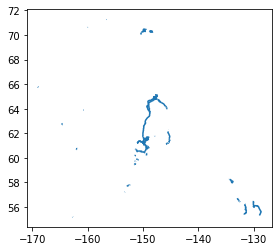

In [ ]:
get_power_lines('alaska')

In [ ]:
area_name='alaska'
gdf = gpd.read_file('/content/drive/MyDrive/ACEP_Data_Team/Railbelt_line/Script_data/alaska-buildinglines.geojson')
print(gdf['power:generator'])


NameError: ignored

 # NO NEED TO RUN CELLS BELOW THIS LINE #

## Get Faroe Islands Data

In [ ]:
!wget http://download.geofabrik.de/europe/faroe-islands-latest.osm.pbf

--2022-02-25 22:27:05--  http://download.geofabrik.de/europe/faroe-islands-latest.osm.pbf
Resolving download.geofabrik.de (download.geofabrik.de)... 116.202.112.212, 95.216.28.113
Connecting to download.geofabrik.de (download.geofabrik.de)|116.202.112.212|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4855945 (4.6M) [application/octet-stream]
Saving to: ‘faroe-islands-latest.osm.pbf’

faroe-islands-lates 100%[===================>]   4.63M  5.20MB/s    in 0.9s    

2022-02-25 22:27:06 (5.20 MB/s) - ‘faroe-islands-latest.osm.pbf’ saved [4855945/4855945]



INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : /content/faroe-islands-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 4814            kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 0.69            s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filter:1.2
INFO:esy.osmfilter.pre_filt

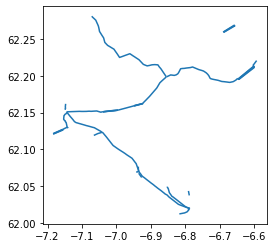

In [ ]:
get_power_lines('faroe-islands')

INFO:esy.osmfilter.pre_filter:PreFilter OSM GAS DATA
INFO:esy.osmfilter.pre_filter:InputFile     : /content/faroe-islands-latest.osm.pbf
INFO:esy.osmfilter.pre_filter:Size          : 4814            kbyte
INFO:esy.osmfilter.pre_filter:Estimated Time: 0.69            s
INFO:esy.osmfilter.pre_filter:=============================
INFO:esy.osmfilter.pre_filter:0.5
INFO:esy.osmfilter.pre_filter:1
INFO:esy.osmfilter.pre_filter:1.3
INFO:esy.osmfilter.pre_filter:2
INFO:esy.osmfilter.pre_filter:3
INFO:esy.osmfilter.pre_filter:Outputfile    : /content/faroe-islands-lines.json
Size          : 12              kbyte 
Time Elapsed  : 7.06            s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.


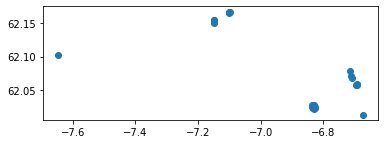

In [ ]:
get_power_plants('faroe-islands')

In [ ]:
!pip install pyrosm

     |████████████████████████████████| 2.1 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached pyrobuf-0.9.3-cp37-cp37m-linux_x86_64.whl
     |████████████████████████████████| 2.1 MB 33.9 MB/s 
  Using cached cykhash-2.0.0-cp37-cp37m-linux_x86_64.whl
     |████████████████████████████████| 1.6 MB 38.1 MB/s 
  Created wheel for pyrosm: filename=pyrosm-0.6.1-cp37-cp37m-linux_x86_64.whl size=5325676 sha256=959fd86e3f1e4f68e21120247955de7e1fabbd02b51314931f7d81016a20c8ff
  Stored in directory: /root/.cache/pip/wheels/e8/9e/d8/e424ffc5eaa71ccb122bb79d92ef75802c49b9b0a9366d6da4
Successfully built pyrosm


In [ ]:
from pyrosm import OSM
from pyrosm import get_data
fp = get_data("taiwan")
# Initialize the OSM parser object
osm = OSM(fp)
buildings = osm.get_buildings()
buildings.plot()

Downloaded Protobuf data 'taiwan-latest.osm.pbf' (99.44 MB) to:
'/tmp/pyrosm/taiwan-latest.osm.pbf'


In [ ]:
from pyrosm import OSM
from pyrosm import get_data
fp = get_data("alaska")
# Initialize the OSM parser object
osm = OSM(fp)
buildings = osm.get_buildings()
buildings.plot()

In [ ]:
from pyrosm.data import sources

# Print available source categories
sources.available.keys()

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


dict_keys(['africa', 'antarctica', 'asia', 'australia_oceania', 'central_america', 'europe', 'north_america', 'south_america', 'cities', 'subregions'])

In [ ]:
print(sources.subregions.usa.available)

['alabama', 'alaska', 'arizona', 'arkansas', 'colorado', 'connecticut', 'delaware', 'district_of_columbia', 'florida', 'georgia', 'hawaii', 'idaho', 'illinois', 'indiana', 'iowa', 'kansas', 'kentucky', 'louisiana', 'maine', 'maryland', 'massachusetts', 'michigan', 'minnesota', 'mississippi', 'missouri', 'montana', 'nebraska', 'nevada', 'new_hampshire', 'new_jersey', 'new_mexico', 'new_york', 'north_carolina', 'north_dakota', 'northern_california', 'ohio', 'oklahoma', 'oregon', 'pennsylvania', 'puerto_rico', 'rhode_island', 'south_carolina', 'south_dakota', 'southern_california', 'tennessee', 'texas', 'utah', 'vermont', 'virginia', 'washington', 'west_virginia', 'wisconsin', 'wyoming']
